# Lab 5: Clustering Analysis

**Name:** Bishal Thapa.  
**Course:** MSCS 634     
**Lab Assignment:** Lab 5 - Hierarchical and DBSCAN Clustering


## Step 1: Data Preparation and Exploration


In [80]:
# Import all the necessary libraries before hand.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [81]:
# Loading the Wine dataset
wine_data = load_wine()
X = wine_data.data
y = wine_data.target
feature_names = wine_data.feature_names
target_names = wine_data.target_names

# Create a DataFrame for easier exploration
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("Dataset shape:", X.shape)
print("\nTarget classes:", target_names)
print("\nNumber of samples per class:")
print(pd.Series(y).value_counts().sort_index())


Dataset shape: (178, 13)

Target classes: ['class_0' 'class_1' 'class_2']

Number of samples per class:
0    59
1    71
2    48
Name: count, dtype: int64


In [82]:
# Examine dataset structure using .head()
print("First 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [83]:
# Examine dataset structure using .info()
print("Dataset information:")
df.info()


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null 

In [84]:
# Examine dataset structure using .describe()
print("Statistical summary of the dataset:")
df.describe()


Statistical summary of the dataset:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [85]:
# Standardizing the dataset's features to ensure they are suitable for clustering. 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame with standardized features
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)

print("Standardized features statistics:")
print(df_scaled.describe())
print("\nStandardized features mean (should be ~0):", df_scaled.mean().mean())
print("Standardized features std (should be ~1):", df_scaled.std().mean())


Standardized features statistics:
            alcohol    malic_acid           ash  alcalinity_of_ash  \
count  1.780000e+02  1.780000e+02  1.780000e+02       1.780000e+02   
mean   7.943708e-15  3.592632e-16 -4.066660e-15      -7.983626e-17   
std    1.002821e+00  1.002821e+00  1.002821e+00       1.002821e+00   
min   -2.434235e+00 -1.432983e+00 -3.679162e+00      -2.671018e+00   
25%   -7.882448e-01 -6.587486e-01 -5.721225e-01      -6.891372e-01   
50%    6.099988e-02 -4.231120e-01 -2.382132e-02       1.518295e-03   
75%    8.361286e-01  6.697929e-01  6.981085e-01       6.020883e-01   
max    2.259772e+00  3.109192e+00  3.156325e+00       3.154511e+00   

          magnesium  total_phenols    flavanoids  nonflavanoid_phenols  \
count  1.780000e+02   1.780000e+02  1.780000e+02          1.780000e+02   
mean  -7.983626e-17  -3.991813e-17  9.979533e-16         -5.588538e-16   
std    1.002821e+00   1.002821e+00  1.002821e+00          1.002821e+00   
min   -2.088255e+00  -2.107246e+00 -1.6

## Step 2: Hierarchical Clustering


In [86]:
# Test different values for n_clusters
n_clusters_list = [ 2, 3, 4, 5]
hierarchical_results = {}

for n_clusters in n_clusters_list:
    # Applying Agglomerative Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = hierarchical.fit_predict(X_scaled)
    
    hierarchical_results[n_clusters] = labels
    
    # Calculate silhouette score
    sil_score = silhouette_score(X_scaled, labels)
    print(f"n_clusters={n_clusters}: Silhouette Score = {sil_score:.4f}")


n_clusters=2: Silhouette Score = 0.2670
n_clusters=3: Silhouette Score = 0.2774
n_clusters=4: Silhouette Score = 0.2258
n_clusters=5: Silhouette Score = 0.1867


## Diagram Use case:
The below diagram visualizes how the hierarchical clustering algorithm assigns clusters to the Wine dataset for different values of n_clusters, using PCA to reduce the data to two dimensions. First, PCA transforms the standardized dataset into two principal components so that the clusters can be viewed on a 2D scatter plot while still preserving most of the dataset’s structure. The code then generates a 2×2 grid of plots, where each subplot corresponds to one value of n_clusters tested during hierarchical clustering. In each subplot, the data points are colored according to the cluster labels produced by the algorithm, allowing you to visually compare how the cluster boundaries change as the number of clusters increases. The axes display the first two principal components along with the percentage of variance they explain, and a color bar shows which color represents which cluster. Overall, the diagram helps to visually understand how hierarchical clustering groups the data and how the choice of n_clusters affects the separation and structure of the resulting clusters.

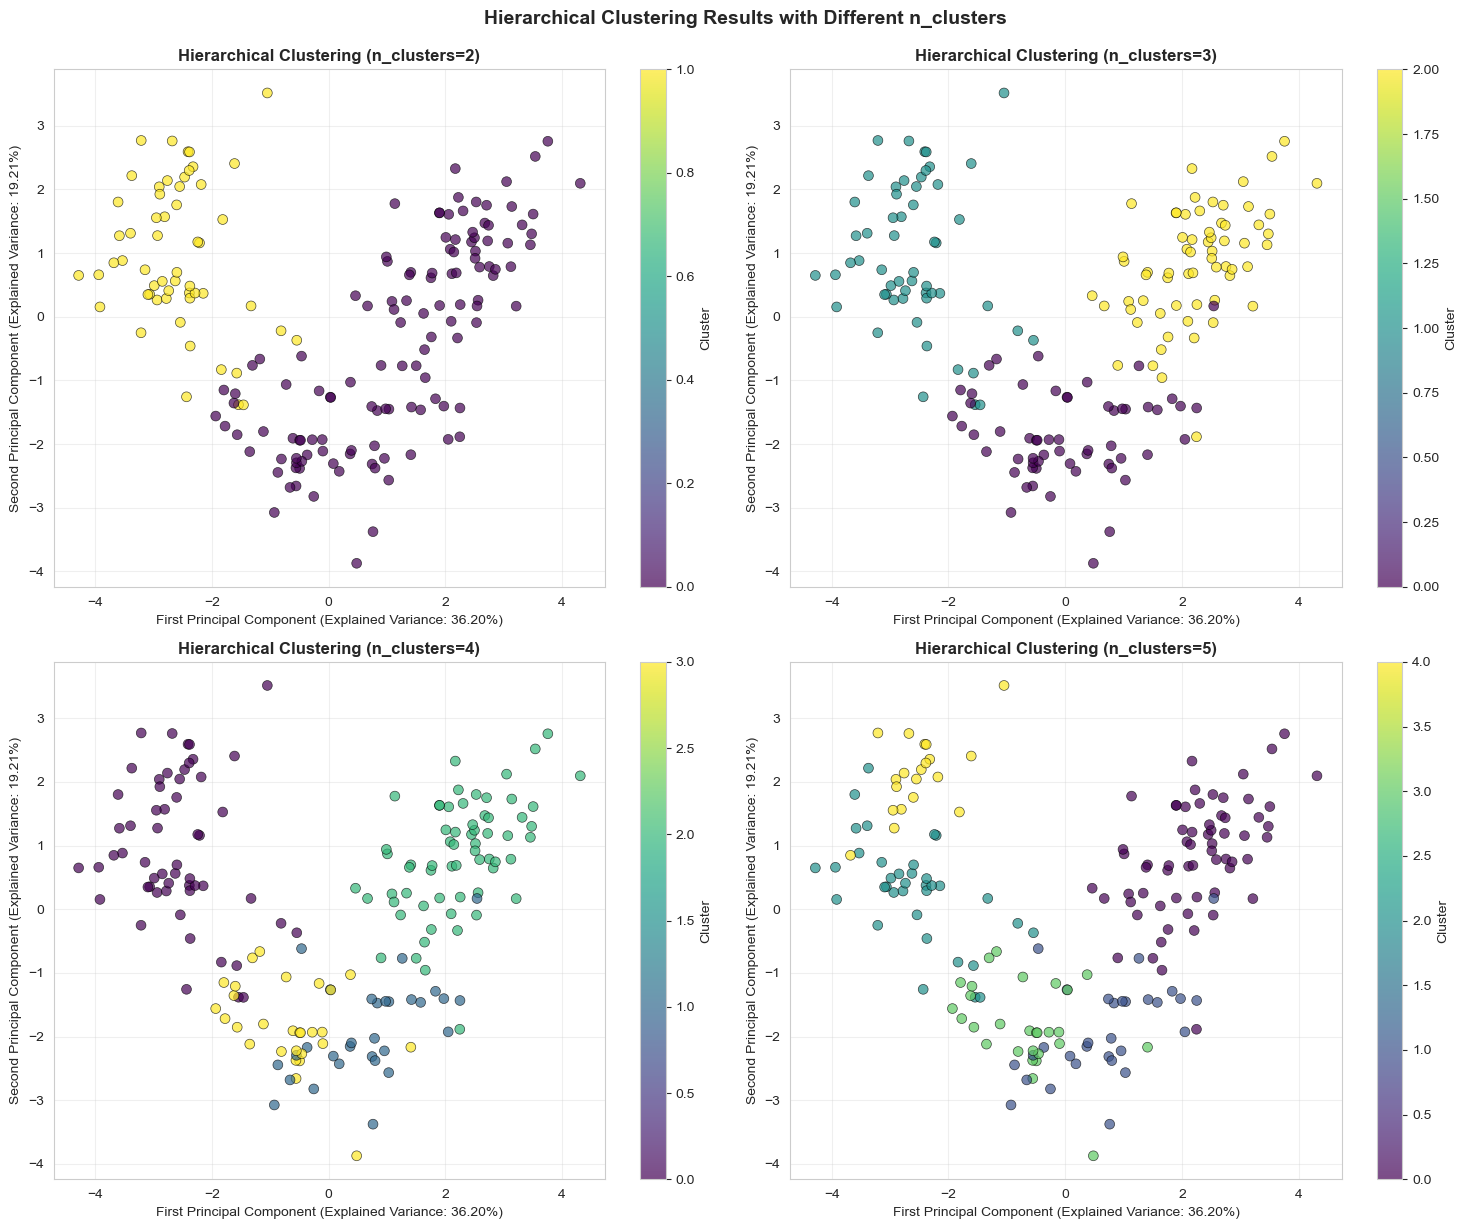

In [88]:
# Visualizing hierarchical clustering results using scatter plots
# Using PCA to reduce dimensions for visualization
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, n_clusters in enumerate(n_clusters_list):
    labels = hierarchical_results[n_clusters]
    ax = axes[idx]
    
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', 
                        s=50, alpha=0.7, edgecolors='black', linewidth=0.5)
    ax.set_title(f'Hierarchical Clustering (n_clusters={n_clusters})', fontsize=12, fontweight='bold')
    ax.set_xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Cluster')

plt.tight_layout()
plt.suptitle('Hierarchical Clustering Results with Different n_clusters', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()


# For the below diagram
The dendrogram shows how clusters merge as their distances change. The vertical axis represents the distance between clusters, and each horizontal line marks a point where two clusters join together. Longer vertical lines indicate that the clusters being merged are more distinct from one another. By choosing different heights at which to “cut” the dendrogram,we can see different numbers of clusters.

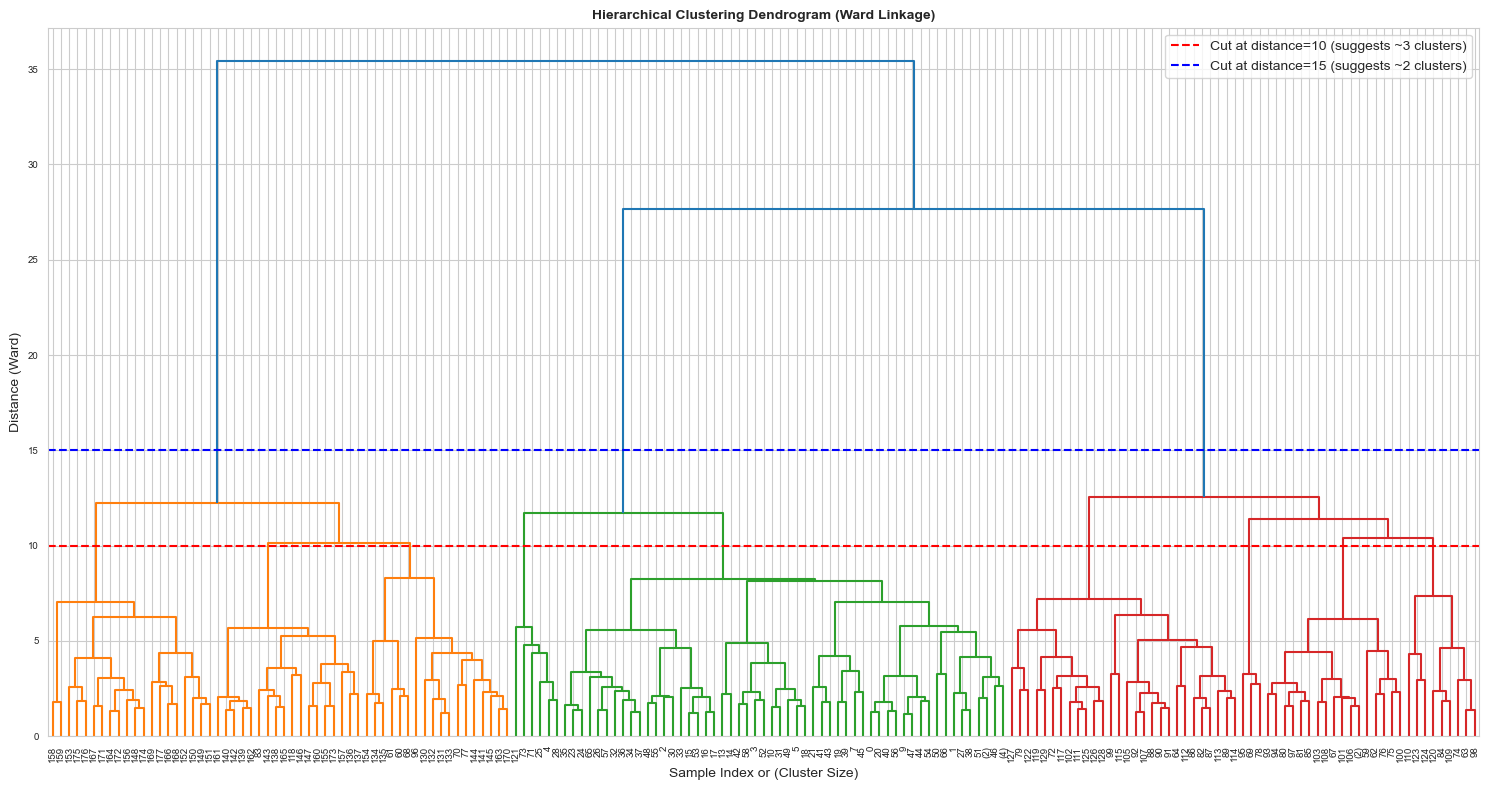

In [68]:
# Generate and interpret a dendrogram
# Compute linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           truncate_mode='level', 
           p=10,  # Show only the last p merged clusters
           leaf_rotation=90,
           leaf_font_size=12,
           show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=10, fontweight='bold')
plt.xlabel('Sample Index or (Cluster Size)', fontsize=10)
plt.ylabel('Distance (Ward)', fontsize=10)
plt.axhline(y=10, color='r', linestyle='--', label='Cut at distance=10 (suggests ~3 clusters)')
plt.axhline(y=15, color='b', linestyle='--', label='Cut at distance=15 (suggests ~2 clusters)')
plt.legend()
plt.tick_params(axis='both', labelsize=7)
plt.tight_layout()
plt.show()


## Step 3: DBSCAN Clustering


In [69]:
# Trying with different values for eps and min_samples
eps_values = [1.0, 1.5, 2.0, 3.0]
min_samples_values = [3,4, 5,6,  7]

dbscan_results = {}
print("DBSCAN Results with Different Parameters:")
print("=" * 60)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        key = f"eps={eps}, min_samples={min_samples}"
        dbscan_results[key] = {
            'labels': labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise
        }
        
        print(f"{key:30s} | Clusters: {n_clusters:2d} | Noise points: {n_noise:3d}")


DBSCAN Results with Different Parameters:
eps=1.0, min_samples=3         | Clusters:  0 | Noise points: 178
eps=1.0, min_samples=4         | Clusters:  0 | Noise points: 178
eps=1.0, min_samples=5         | Clusters:  0 | Noise points: 178
eps=1.0, min_samples=6         | Clusters:  0 | Noise points: 178
eps=1.0, min_samples=7         | Clusters:  0 | Noise points: 178
eps=1.5, min_samples=3         | Clusters:  8 | Noise points: 147
eps=1.5, min_samples=4         | Clusters:  2 | Noise points: 169
eps=1.5, min_samples=5         | Clusters:  0 | Noise points: 178
eps=1.5, min_samples=6         | Clusters:  0 | Noise points: 178
eps=1.5, min_samples=7         | Clusters:  0 | Noise points: 178
eps=2.0, min_samples=3         | Clusters:  5 | Noise points:  64
eps=2.0, min_samples=4         | Clusters:  6 | Noise points:  66
eps=2.0, min_samples=5         | Clusters:  5 | Noise points:  85
eps=2.0, min_samples=6         | Clusters:  3 | Noise points: 100
eps=2.0, min_samples=7         | C

# Diagram Explanation

This diagram shows how the DBSCAN clustering algorithm behaves under different parameter settings by plotting the resulting clusters for several combinations of eps and min_samples. Each subplot represents one specific parameter combination and displays the data (projected onto two principal components using PCA) with points colored according to the cluster they belong to, while noise points are marked in black with an “x”. The diagram helps you visually compare how different parameter values change the number of clusters formed, how many points are considered noise, and how clearly the clusters separate. It also includes titles summarizing cluster counts and noise levels for each configuration, allowing you to easily evaluate which parameter choices produce meaningful, well-defined clusters.

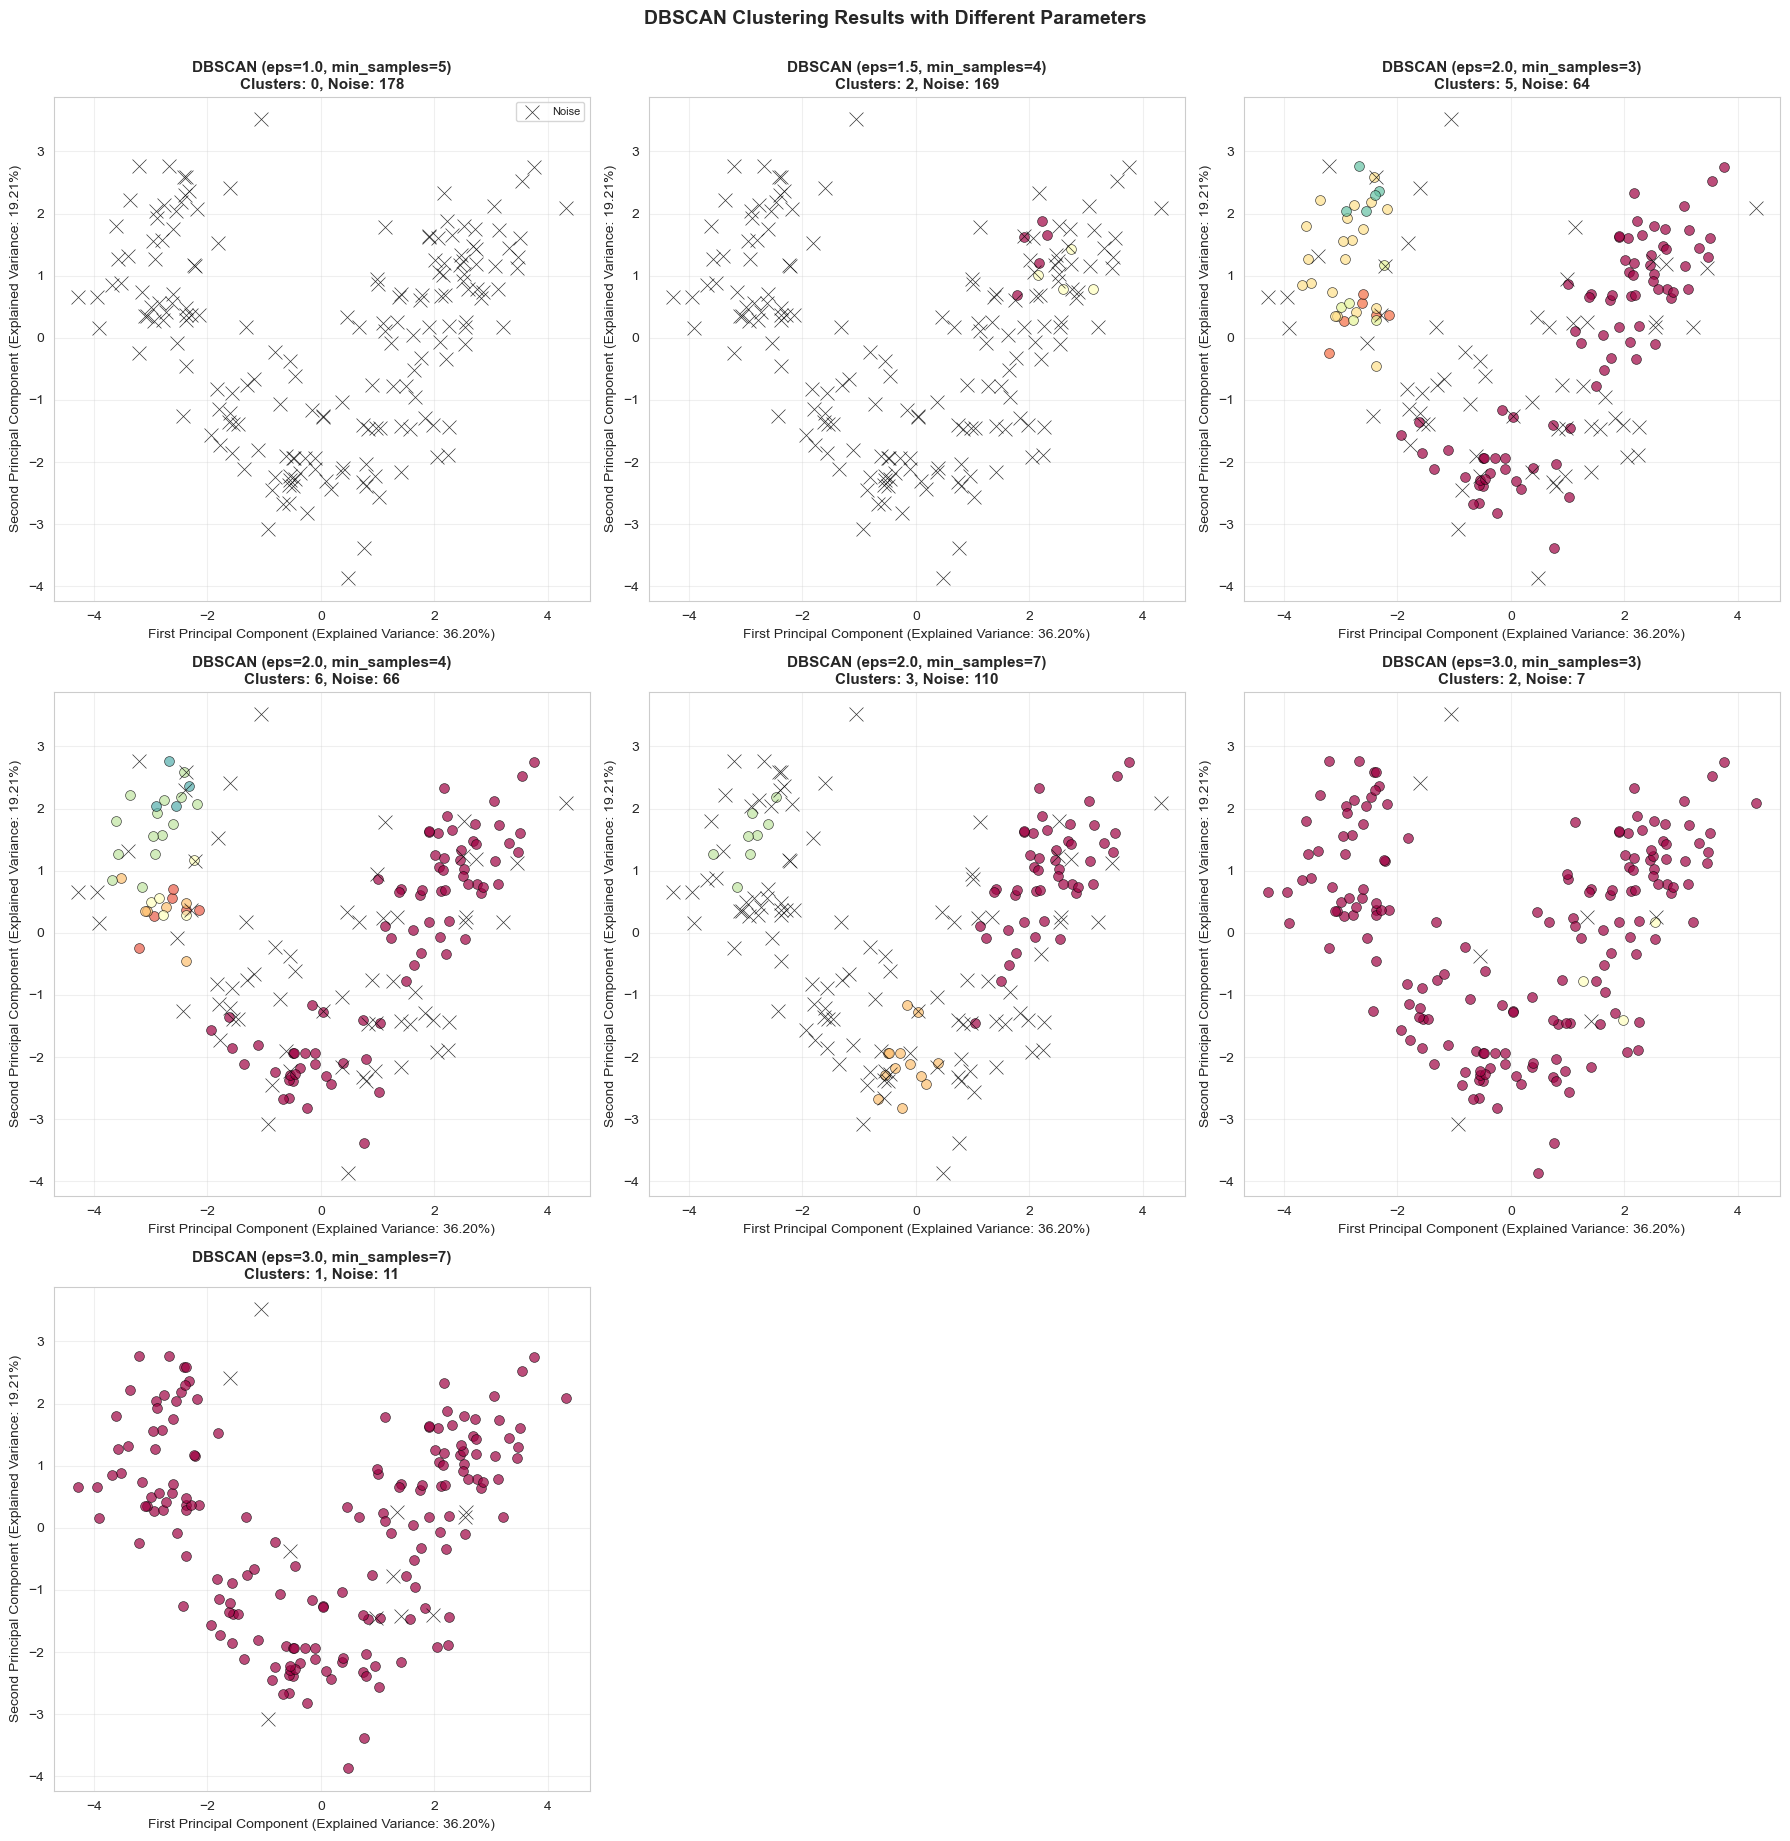

In [71]:
# Visualize DBSCAN results with different parameters
# Visualizing few interesting parameter combinations
selected_params = [
    ('eps=1.0', 'min_samples=5'),
    ('eps=1.5', 'min_samples=4'),
    ('eps=2.0', 'min_samples=3'),
    ('eps=2.0', 'min_samples=4'),
    ('eps=2.0', 'min_samples=7'),
    ('eps=3.0', 'min_samples=3'),
    ('eps=3.0', 'min_samples=7')
]

# Dynamically adjusting subplot grid to accommodate all parameter combinations
n_plots = len(selected_params)
n_cols = 3  # 3 columns per row
n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.ravel() if n_rows > 1 else [axes] if n_cols == 1 else axes.ravel()

for idx, (eps_str, min_samples_str) in enumerate(selected_params):
    eps_val = float(eps_str.split('=')[1])
    min_samples_val = int(min_samples_str.split('=')[1])
    key = f"eps={eps_val}, min_samples={min_samples_val}"
    
    labels = dbscan_results[key]['labels']
    n_clusters = dbscan_results[key]['n_clusters']
    n_noise = dbscan_results[key]['n_noise']
    
    ax = axes[idx]
    
    # Plot clusters
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black for noise points
            col = 'black'
            marker = 'x'
            size = 100
            alpha = 0.8
        else:
            marker = 'o'
            size = 50
            alpha = 0.7
        
        class_member_mask = (labels == k)
        xy = X_pca[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, 
                  s=size, alpha=alpha, edgecolors='black' if k != -1 else None, 
                  linewidth=0.5, label=f'Cluster {k}' if k != -1 else 'Noise')
    
    ax.set_title(f'DBSCAN (eps={eps_val}, min_samples={min_samples_val})\n'
                 f'Clusters: {n_clusters}, Noise: {n_noise}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(loc='upper right', fontsize=8)

# Hide any unused subplots
for i in range(n_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('DBSCAN Clustering Results with Different Parameters', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()


In [76]:
# Compute and report metrics for DBSCAN clustering
# Select a few representative parameter combinations for detailed evaluation
evaluation_params = [
('eps=1.0', 'min_samples=5'),
('eps=1.5', 'min_samples=3'),
('eps=1.5', 'min_samples=4'),
('eps=1.5', 'min_samples=5'),
('eps=1.5', 'min_samples=7'),
('eps=2.0', 'min_samples=3'),
('eps=2.0', 'min_samples=4'),
('eps=2.0', 'min_samples=5'),
('eps=2.0', 'min_samples=7'),
('eps=3.0', 'min_samples=3'),
('eps=3.0', 'min_samples=7')
]

print("DBSCAN Clustering Quality Metrics:")
print("-" * 80)
print(f"{'Parameters':<30s} | {'Silhouette':<12s} | {'Homogeneity':<12s} | {'Completeness':<12s} | {'Clusters':<8s} | {'Noise':<6s}")
print("-" * 80)

metrics_results = {}

for eps_str, min_samples_str in evaluation_params:
    eps_val = float(eps_str.split('=')[1])
    min_samples_val = int(min_samples_str.split('=')[1])
    key = f"eps={eps_val}, min_samples={min_samples_val}"
    
    labels = dbscan_results[key]['labels']
    n_clusters = dbscan_results[key]['n_clusters']
    n_noise = dbscan_results[key]['n_noise']
    
    # Only compute metrics if we have at least 2 clusters and not all points are noise
    if n_clusters >= 2 and n_noise < len(labels):
        # Filter out noise points for silhouette score calculation
        mask = labels != -1
        if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
            sil_score = silhouette_score(X_scaled[mask], labels[mask])
        else:
            sil_score = -1
        
        # Homogeneity and Completeness (using true labels for comparison)
        if n_clusters > 0:
            hom_score = homogeneity_score(y, labels)
            com_score = completeness_score(y, labels)
        else:
            hom_score = 0
            com_score = 0
    else:
        sil_score = -1
        hom_score = 0
        com_score = 0
    
    metrics_results[key] = {
        'silhouette': sil_score,
        'homogeneity': hom_score,
        'completeness': com_score,
        'n_clusters': n_clusters,
        'n_noise': n_noise
    }
    
    print(f"{key:<30s} | {sil_score:>11.4f} | {hom_score:>11.4f} | {com_score:>11.4f} | {n_clusters:>7d} | {n_noise:>5d}")



DBSCAN Clustering Quality Metrics:
--------------------------------------------------------------------------------
Parameters                     | Silhouette   | Homogeneity  | Completeness | Clusters | Noise 
--------------------------------------------------------------------------------
eps=1.0, min_samples=5         |     -1.0000 |      0.0000 |      0.0000 |       0 |   178
eps=1.5, min_samples=3         |      0.3311 |      0.1892 |      0.2510 |       8 |   147
eps=1.5, min_samples=4         |      0.4067 |      0.0540 |      0.2495 |       2 |   169
eps=1.5, min_samples=5         |     -1.0000 |      0.0000 |      0.0000 |       0 |   178
eps=1.5, min_samples=7         |     -1.0000 |      0.0000 |      0.0000 |       0 |   178
eps=2.0, min_samples=3         |      0.2113 |      0.4423 |      0.3724 |       5 |    64
eps=2.0, min_samples=4         |      0.2209 |      0.4268 |      0.3447 |       6 |    66
eps=2.0, min_samples=5         |      0.2405 |      0.3624 |      0.32

A silhouette score of -1 indicates that there were not enough clusters to compute the score. Homogeneity measures how well each cluster contains only data points from a single class, while completeness measures how well all data points belonging to the same class are grouped together within the clusters.

## Step 4: Analysis and Insights


### Comparison of Hierarchical and DBSCAN Clustering
The hierarchical clustering results were consistent and predictable, producing between two and five clusters with silhouette scores ranging from 0.18 to 0.28. This indicates that the dataset has only moderately separable structure under hierarchical clustering. In contrast, DBSCAN produced highly variable results depending on the parameters. For small eps values such as 1.0, DBSCAN detected no clusters at all, while medium eps values like 1.5 and 2.0 resulted in anywhere from 2 to 8 clusters, and larger eps values like 3.0 produced very few, very large clusters. Overall, hierarchical clustering provided stable solutions, while DBSCAN offered more diverse but also more sensitive outcomes.


### Influence of Parameter Choices on Clustering Outcomes
The hierarchical method depends mainly on the number of clusters selected, and changes in this parameter only slightly influenced the silhouette scores, showing that the algorithm forces a structure onto the data even when that structure is weak. DBSCAN, however, was extremely sensitive to the parameters eps and min_samples. A small eps prevented clusters from forming, producing only noise. Increasing eps to moderate values caused clusters to emerge, but varying min_samples at the same eps changed both the number of clusters and the amount of noise. At higher eps levels, the clusters became overly large and less meaningful. This demonstrates that DBSCAN’s results depend heavily on tuning its parameters, especially eps, which controls neighborhood size.

### Strengths and Weaknesses of Each Algorithm Based on Your Results
Hierarchical clustering showed strength in providing stable and interpretable cluster structures without requiring much parameter tuning. It always returned clusters, even when the underlying structure was weak, making it reliable but sometimes artificially restrictive. Its weakness is that it cannot identify noise or irregular shapes and may force data into clusters that are not meaningful. DBSCAN, on the other hand, excelled at identifying noise points and detecting complex cluster shapes when parameters were appropriately chosen. It was able to isolate dense groups and treat outliers separately, which hierarchical clustering cannot do. However, its major weakness is sensitivity to eps: poor parameter selection leads to no clusters or overly coarse clustering. This makes DBSCAN powerful but less predictable and more dependent on careful tuning.
